**[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image associated with a label from 10 classes. The dataset serves as a direct drop-in replacement for the original [MNIST dataset](http://yann.lecun.com/exdb/mnist/) for benchmarking machine learning algorithms. It shares the same image size and structure for training and testing splits.**

**In my IT3312 - AI Technologies Module's Individual Assignment, I will utilize the pre-trained VGG19 model, developed by Karen Simonyan and Andrew Zisserman in 2014. VGG19 is a straightforward and popular convolutional neural network architecture used for ImageNet. I will train the model for 10 epochs with a batch size of 256, using the categorical_crossentropy loss function and the Adam optimizer.**

**Done By: Sandhya Palaniappan.**

### **Data Processing.**
**I am loading the training and testing CSV files.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Load training and test data into dataframes
data_train = pd.read_csv('data/fashion-mnist_train.csv')
data_test = pd.read_csv('data/fashion-mnist_test.csv')

# X forms the training images, and y forms the training labels
X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

# X_test forms the test images, and y_test forms the test labels
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


**The images in the fashionMNIST dataset are black and white, whereas VGG19 requires colored images as input.** 

**Therefore, I will convert the images into colored ones with 3 channels: Red (R), Green (G), and Blue (B).**

In [2]:
# Convert the training and test images into 3 channels
X = np.dstack([X] * 3)
X_test = np.dstack([X_test]*3)

# Display their new shapes
X.shape, X_test.shape

((60000, 784, 3), (10000, 784, 3))

**Let's reshape the images into the tensor format required by TensorFlow.**

In [3]:
# Reshape images as per the tensor format required by tensorflow
X = X.reshape(-1, 28,28,3)
X_test= X_test.reshape (-1,28,28,3)

# Display the new shape
X.shape, X_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

**VGG19 requires input images to have a minimum width and height of 48 pixels. However, I will resize my images from 28x28 to 150x150 pixels.**

In [4]:
# Resize the images as 150 * 150 as required by VGG19
from keras.preprocessing.image import img_to_array, array_to_img

X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((150,150))) for im in X])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((150,150))) for im in X_test])

# Display the new shape
X.shape, X_test.shape

((60000, 150, 150, 3), (10000, 150, 150, 3))

**Here, I preprocess the images by reshaping them into the format the network expects and scaling them so that all values fall within the [0, 1] range.** 

**E.g., the training images, initially stored in an array of shape (60000, 150, 150, 3) of type uint8 with values ranging from [0, 255], are transformed into a float32 array of shape (60000, 150, 150, 3) with values between 0 and 1.**

In [5]:
# Normalise the data and change data type
X = X.astype('float32')
X /= 255

X_test = X_test.astype('float32')
X_test /= 255

**Here, I split the original training data (60,000 images) into 80% for training (48,000 images) and 20% for validation (12,000 images) to optimize the classifier.** 

**The test data (10,000 images) is kept separate to evaluate the model's accuracy on unseen data. This process helps determine if overfitting occurs.** 

**If the validation accuracy is higher than the training accuracy, I might lower the learning rate and train for more epochs.** 

**Conversely, if the training accuracy surpasses the validation accuracy significantly, I would stop training to prevent overfitting.**





In [6]:
from sklearn.model_selection import train_test_split

# Here I split original training data to sub-training (80%) and validation data (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

# Check the data size whether it is as per tensorflow and VGG19 requirement
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((48000, 150, 150, 3), (12000, 150, 150, 3), (48000, 10), (12000, 10))

### **VGG19.**
**A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A pretrained network is a saved network previously trained on a large dataset, typically for a large-scale image-classification task. If this original dataset is large and general enough, the spatial hierarchy of features learned by the pretrained network can serve as a generic model of the visual world. These features can be useful for various computer vision problems, even if these new problems involve completely different classes from those of the original task.**

**I will use the [VGG19 architecture](https://arxiv.org/abs/1409.1556), developed by Karen Simonyan and Andrew Zisserman in 2014.** 

**VGG19 is a simple and widely used convolutional network architecture for ImageNet. The model is pre-packaged with Keras.**

**Let's create it:**

In [7]:
from keras.applications import VGG19

# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (150, 150, 3), classes = 10)

**I passed four arguments to the constructor:**
* **weights: Specifies the weight checkpoint from which to initialize the model.**
* **include_top: Determines whether to include the densely connected classifier on top of the network. By default, this classifier corresponds to the 1,000 classes from ImageNet. Since I will use my own densely connected classifier with only 10 classes, I don’t need to include it.**
* **input_shape: An optional shape tuple, specified only if include_top is False.**
* **classes: The optional number of classes to classify images into, specified only if include_top is True and no weights argument is provided.**

**Here's the detailed architecture of the VGG19 convolutional base.**

In [8]:
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### **Feature Extraction.**
**Feature extraction involves using the representations learned by a pre-trained network to extract relevant features from new samples. These features are then passed through a new classifier, which is trained from scratch.**

**CNNs used for image classification have two main parts: a series of pooling and convolution layers, and a densely-connected classifier. The first part is known as the "convolutional base" of the model. In the case of convnets, "feature extraction" involves taking the convolutional base of a pre-trained network, running new data through it, and training a new classifier on top of the output.**

**Why only reuse the convolutional base and not the densely-connected classifier as well? Generally, it is best to avoid reusing the densely-connected classifier. The reason is that the representations learned by the convolutional base are more generic and therefore more reusable. The feature maps of a convnet are presence maps of generic concepts over an image, making them useful for various computer vision problems. In contrast, the representations learned by the classifier are highly specific to the classes the model was originally trained on and only provide information about the presence probability of specific classes in the entire image. Additionally, the densely-connected layers lose information about the location of objects in the input image, which is retained in the convolutional feature maps. For problems where object location is important, the densely-connected features are largely useless.**

**In the VGG19 architecture, the final feature map has a shape of (4, 4, 512). This is the feature map on which I will build a densely-connected classifier. First, let's preprocess the data so it is compatible with VGG19 for training.**

In [9]:
from keras.applications.vgg19 import preprocess_input

# Preprocessing the input 
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

**To extract features from the Fashion-MNIST dataset, I will:**
* **Run the convolutional base over the dataset.**
* **Record its output to a NumPy array on disk.**
* **Use this data as input to a standalone densely-connected classifier.**

**This approach is very efficient and cost-effective because it requires running the convolutional base only once for each input image. The convolutional base is the most computationally intensive part of the pipeline. However, this method does not allow for the use of data augmentation.**

**Next, I will extract features from the training, testing, and validation data by simply calling the predict method of the VGG19 model.**

In [10]:
# Extracting features
train_features = vgg19.predict(np.array(X_train), batch_size=256, verbose=1)
test_features = vgg19.predict(np.array(X_test), batch_size=256, verbose=1)
val_features = vgg19.predict(np.array(X_val), batch_size=256, verbose=1)

12000/12000 [==============================] - 72s 6ms/step


In [11]:
# Saving the features so that they can be used for future
np.savez("train_features", train_features, y_train)
np.savez("test_features", test_features, y_test)
np.savez("val_features", val_features, y_val)

In [12]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

((48000, 4, 4, 512), '\n', (10000, 4, 4, 512), '\n', (12000, 4, 4, 512))


**The extracted features currently have the shape (samples, 4, 4, 512).** 

**To feed them into a densely-connected classifier, I need to first flatten them to (samples, 8192):**

In [13]:
# Flatten extracted features
train_features = np.reshape(train_features, (48000, 4*4*512))
test_features = np.reshape(test_features, (10000, 4*4*512))
val_features = np.reshape(val_features, (12000, 4*4*512))

**At this stage, I can define the densely-connected classifier, incorporating dropout for regularization. Then, I will train it on the data and labels that I have recorded:**

In [14]:
from keras.layers import Dense, Dropout
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

**When compiling the model, I select categorical_crossentropy as the loss function, which is appropriate for a multiclass, single-label classification problem, and the Adam optimizer.**
* **The cross-entropy loss measures the error rate between the predicted value and the actual value. Do find the formula for calculating cross-entropy loss [here](https://en.wikipedia.org/wiki/Cross_entropy).**
* **Categorical cross-entropy is used because there are 10 classes to predict. If there were only 2 classes, I would use binary_crossentropy.**
* **The Adam optimizer is an improvement over Stochastic Gradient Descent (SGD). It updates the weights of the neurons via backpropagation by calculating the derivative of the loss function with respect to each weight and subtracting it from the weight. This is how a neural network learns.**

In [15]:
import keras

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

### **Training the Model.**
**As mentioned earlier, I train the model with a batch size of 256 for 10 epochs using both the training and validation data.**

In [16]:
# Train the the model
history = model.fit(train_features, y_train,
          batch_size=256,
          epochs=50,
          verbose=1,
          validation_data=(val_features, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 3s 67us/step - loss: 1.9221 - acc: 0.3443 - val_loss: 1.3791 - val_acc: 0.6001
Epoch 2/50
48000/48000 [==============================] - 3s 56us/step - loss: 1.2921 - acc: 0.5343 - val_loss: 1.0462 - val_acc: 0.6325
Epoch 3/50
48000/48000 [==============================] - 3s 55us/step - loss: 1.1065 - acc: 0.6021 - val_loss: 0.9350 - val_acc: 0.6776
Epoch 4/50
48000/48000 [==============================] - 3s 56us/step - loss: 1.0226 - acc: 0.6267 - val_loss: 0.9029 - val_acc: 0.6947
Epoch 5/50
48000/48000 [==============================] - 3s 55us/step - loss: 0.9720 - acc: 0.6465 - val_loss: 0.8144 - val_acc: 0.6997
Epoch 6/50
48000/48000 [==============================] - 3s 55us/step - loss: 0.9393 - acc: 0.6546 - val_loss: 0.7923 - val_acc: 0.7165
Epoch 7/50
48000/48000 [==============================] - 3s 55us/step - loss: 0.9196 - acc: 0.6638 - val_loss: 0.7616 - val_acc

In [17]:
score = model.evaluate(test_features, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.6238402219772339)
('Test accuracy:', 0.7664)


**The test accuracy using the pre-trained model is only 76.64%.**

### **Results.**
**Let's plot the training and validation accuracy, along with the training and validation loss.**

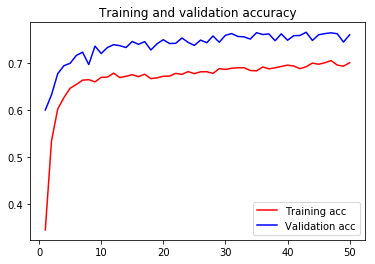

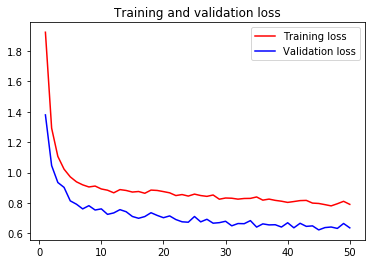

In [18]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

**Although the loss and accuracy lines for both training and validation follow similar trends, there is a noticeable gap between their values.**

### **Classification Report.**
**The performance of my classifier can be summarized as follows:**

In [19]:
# get the predictions for the test data
predicted_classes = model.predict_classes(test_features)

# get the indices to be plotted
y_true = data_test.iloc[:, 0]
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [20]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.63      0.83      0.71      1000
    Class 1       0.94      0.95      0.95      1000
    Class 2       0.68      0.56      0.61      1000
    Class 3       0.81      0.79      0.80      1000
    Class 4       0.62      0.76      0.68      1000
    Class 5       0.77      0.95      0.85      1000
    Class 6       0.50      0.27      0.35      1000
    Class 7       0.89      0.77      0.82      1000
    Class 8       0.87      0.94      0.90      1000
    Class 9       0.91      0.85      0.88      1000

avg / total       0.76      0.77      0.76     10000



**The model underperforms for Classes 2 and 6. Additionally, it lacks precision for Classes 0 and 4.**

In [21]:
test_features[correct].shape

(7664, 8192)

### **Conclusion.**

**In this individual assignment, I utilized the VGG19 pre-trained model to classify images from the Fashion-MNIST dataset. After converting grayscale images to RGB, resizing them, and extracting features, the model achieved a test accuracy of 76.64%. While this performance is respectable, it indicates room for improvement.**

**Future work could include hyperparameter tuning, more sophisticated data augmentation techniques, and exploring additional layers or different architectures to enhance accuracy. Overall, this individual assignment demonstrated the effective use of transfer learning and provided insights into leveraging pre-trained models for specific classification tasks.**
